In [1]:
import sys
sys.path.append('../src/')
import os
import math
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

from models import *
from priors import *
from utils import *

In [38]:
df = load_experiment('/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/BUSI_short_range.csv')
# Take mean of each random seed at each dataset size
df = df.groupby('n').agg(lambda x: list(x))
df.test_auroc = df.test_auroc.apply(lambda x: np.mean(x, axis=0))
df.random_state = df.random_state.apply(lambda x: 'mean')
df = df.reset_index()

In [39]:
index = 0
X_train, y_train, X_test, y_test = split_df(df, index=index)
model, losses = train_PowerLaw(X_train, y_train)
model.eval()

PowerLaw(
  (softplus): Softplus(beta=1, threshold=20)
)

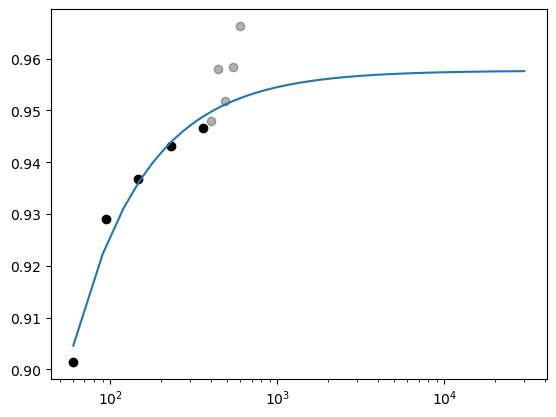

In [40]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    loc = model(torch.linspace(60, 30000, 1000))
plt.scatter(X_train, y_train, color='black', alpha=1.0, label='Initial subsets')
plt.scatter(X_test, y_test, color='black', alpha=0.3, label='Ground truth')
plt.plot(np.linspace(60, 30000, 1000), loc, color='#1f77b4', label='Gaussian process (ours)')
plt.xscale('log')
plt.show()

In [33]:
index = 0
X_train, y_train, X_test, y_test = split_df(df, index=index)
likelihood, model, losses = train_GPPowerLaw(X_train, y_train)
likelihood.eval()
model.eval()

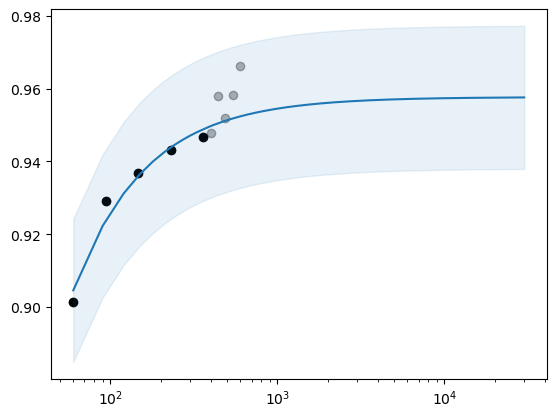

In [37]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(torch.linspace(60, 30000, 1000)))
loc = observed_pred.mean.numpy()
scale = observed_pred.stddev.numpy()
lower, upper = truncated_normal_uncertainty(0, 1, loc, scale)
plt.scatter(X_train, y_train, color='black', alpha=1.0, label='Initial subsets')
plt.scatter(X_test, y_test, color='black', alpha=0.3, label='Ground truth')
plt.plot(np.linspace(60, 30000, 1000), loc, color='#1f77b4', label='Gaussian process (ours)')
plt.fill_between(np.linspace(60, 30000, 1000), lower, upper, color='#1f77b4', alpha=0.1)
plt.xscale('log')
plt.show()

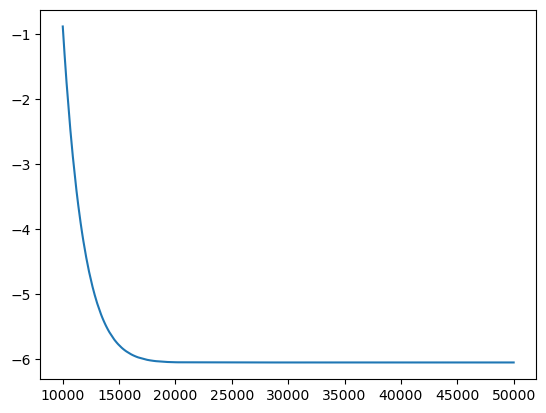

In [35]:
plt.plot(list(range(len(losses)))[10000:], losses[10000:])
plt.show()

torch.Size([5, 5])


RuntimeError: INDICES element is out of DATA bounds, id=5 axis_dim=1

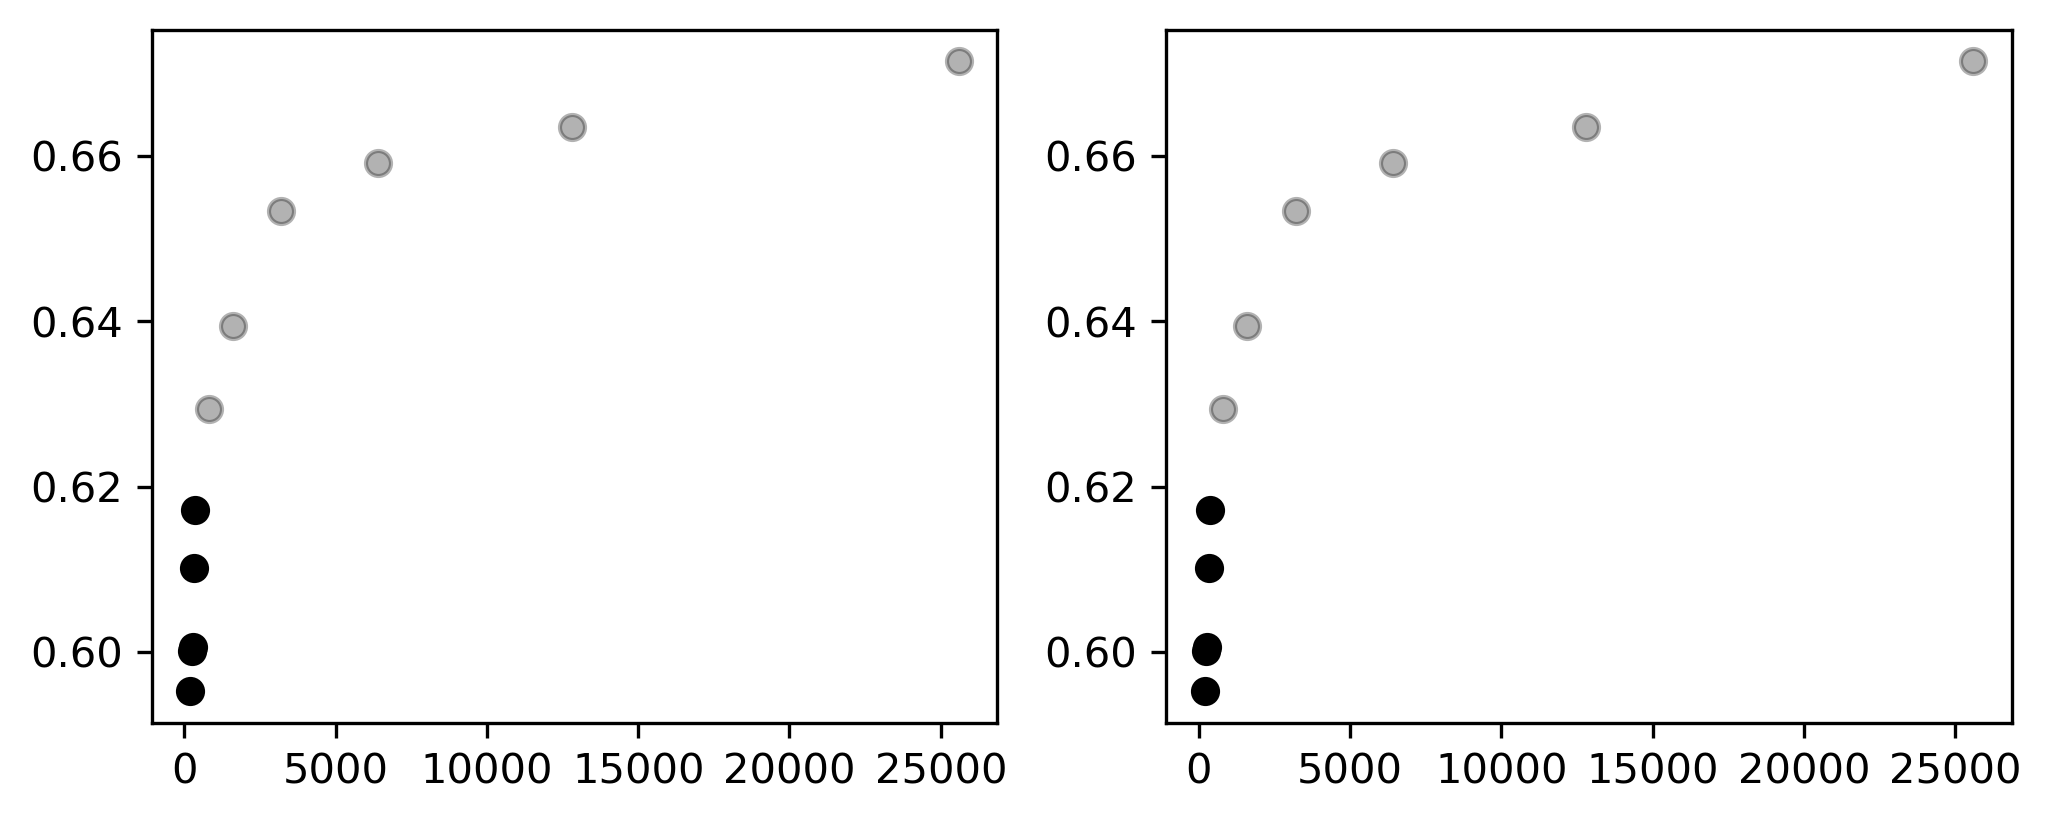

In [41]:
index = 2
labels = ['Atelectasis', 'Effusion', 'Infiltration']
ncols, nrows = 2, 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*4, nrows*3), dpi=300)
# Plot data
for col_index in range(ncols):
    np.array(axs).flatten()[col_index]\
    .scatter(df[df.n<=360].n.to_numpy(),
             np.array(df[df.n<=360].test_auroc.to_list())[:,index],
             color='black',
             alpha=1.0,
             label='Initial subsets')
    np.array(axs).flatten()[col_index]\
    .scatter(df[df.n>360].n.to_numpy(),
             np.array(df[df.n>360].test_auroc.to_list())[:,index],
             color='black',
             alpha=0.3,
             label='Ground truth')
# Split data
X_train, y_train, X_test, y_test = split_df(df, index=index)
# Train power law model
#model, losses = train_PowerLaw(X_train, y_train)
#model.eval()
#with torch.no_grad():
#    observed_pred = model(torch.linspace(200, 30000, 1000))
#np.array(axs).flatten()[0]\
#.plot(np.linspace(200, 30000, 1000), observed_pred.numpy(), color='#d62728', label='Power law')
# Train Gaussian process
likelihood, model, losses = train_GPPowerLaw(X_train, y_train)
likelihood.eval()
model.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(torch.linspace(200, 30000, 1000)))
loc = observed_pred.mean.numpy()
scale = observed_pred.stddev.numpy()
lower, upper = truncated_normal_uncertainty(0, 1, loc, scale)   
np.array(axs).flatten()[1]\
.plot(np.linspace(200, 30000, 1000), loc/(torch.linspace(200, 30000, 1000)/torch.sum(torch.linspace(200, 30000, 1000))), color='#1f77b4', label='Gaussian process (ours)')
np.array(axs).flatten()[1]\
.fill_between(np.linspace(200, 30000, 1000), lower/(torch.linspace(200, 30000, 1000)/torch.sum(torch.linspace(200, 30000, 1000))), upper/(torch.linspace(200, 30000, 1000)/torch.sum(torch.linspace(200, 30000, 1000))), color='#1f77b4', alpha=0.1)
# Formatting
for col_index in range(ncols):
    np.array(axs).flatten()[col_index]\
    .set_ylim([0.5, 1.0])
    np.array(axs).flatten()[col_index]\
    .set_xscale('log')
    np.array(axs).flatten()[col_index]\
    .set_xlabel('Number of training samples (log-scale)')
    np.array(axs).flatten()[col_index]\
    .set_ylabel('{} AUROC'.format(labels[index]))
    #np.array(axs).flatten()[col_index]\
    #.legend(loc='lower right')
    np.array(axs).flatten()[col_index]\
    .legend()
    np.array(axs).flatten()[col_index]\
    .grid()
fig.tight_layout()
plt.show()

In [19]:
training = np.logspace(np.log10(60),np.log10(360), 5, base=10)
short_range = np.logspace(np.log10(360),np.log10(720), 6, base=10)[1:]
long_range = np.logspace(np.log10(360),np.log10(20000), 6, base=10)[1:]
print(np.round(training, decimals=0).astype(int))
print(np.round(short_range, decimals=0).astype(int))
print(np.round(long_range, decimals=0).astype(int))

[ 60  94 147 230 360]
[414 475 546 627 720]
[  804  1796  4010  8955 20000]
